# Config => Pose.py

In [1]:
__config__ = {
    'data_provider': 'data.MPII.dp',
    'network': 'models.posenet.PoseNet',
    'inference': {
        'nstack': 8,
        'inp_dim': 256,
        'oup_dim': 16,
        'num_parts': 16,
        'increase': 0,
        'keys': ['imgs'],
        'num_eval': 2958, ## number of val examples used. entire set is 2958
        'train_num_eval': 300, ## number of train examples tested at test time
    },

    'train': {
        'batchsize': 16,
        'input_res': 256,
        'output_res': 64,
        'train_iters': 1000,
        'valid_iters': 10,
        'learning_rate': 1e-3,
        'max_num_people' : 1,
        'loss': [
            ['combined_hm_loss', 1],
        ],
        'decay_iters': 100000,
        'decay_lr': 2e-4,
        'num_workers': 2,
        'use_data_loader': True,
    },
}

# dp => input image => crop 256X256 
# make heatmap 64X64
# random rotate => keypoint => rotate
## img.kpt_affine => same random rotate

In [2]:
import cv2
import sys
import os
import torch
import numpy as np
import torch.utils.data


import img


In [3]:
import ref as ds1

In [4]:
config=__config__

In [5]:
batchsize=config['train']['batchsize']

In [6]:
batchsize

16

In [7]:
# current_path = os.path.dirname(os.path.abspath(__file__))

# 현재 수행중인 위치

In [8]:
import ref as ds
ds.init()

loading data...
Done (t=3.36s)


# part of heatmap

In [9]:
output_res=config['train']['output_res']
num_parts=config['inference']['num_parts']
input_res=config['train']['input_res']

In [10]:
sigma = output_res/64
size =6*sigma+3

In [11]:
x = np.arange(0, size, 1, float)

In [12]:
x

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [13]:
y = x[:, np.newaxis]

In [14]:
y

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.],
       [6.],
       [7.],
       [8.]])

In [15]:
x0, y0 = 3*sigma + 1, 3*sigma + 1

In [16]:
x0, y0

(4.0, 4.0)

In [17]:
g=np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

In [18]:
g.shape

(9, 9)

### make heatmap

In [19]:
hms=np.zeros(shape=(num_parts, output_res, output_res),dtype=np.float32)

In [20]:
mpii=ds.MPII()

loading data...
Done (t=3.40s)


In [21]:
mpii.getAnnots(1)

('015601864.jpg',
 array([[ 895.,  293.],
        [ 910.,  279.],
        [ 945.,  223.],
        [1012.,  218.],
        [ 961.,  315.],
        [ 960.,  403.],
        [ 979.,  221.],
        [ 906.,  190.],
        [ 912.,  190.],
        [ 830.,  182.],
        [ 871.,  304.],
        [ 883.,  229.],
        [ 888.,  174.],
        [ 924.,  206.],
        [1013.,  203.],
        [ 955.,  263.]]),
 array([1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.]),
 array([952.        , 259.08174753]),
 3.0901456276363417,
 61.80291255272683)

In [22]:
img_name,part,visible,center,scale,normalize=mpii.getAnnots(0)

In [23]:
orig_keypoints=ds.get_kps(1)

In [24]:
orig_keypoints

array([[[8.950e+02, 2.930e+02, 1.000e+00],
        [9.100e+02, 2.790e+02, 1.000e+00],
        [9.450e+02, 2.230e+02, 0.000e+00],
        [1.012e+03, 2.180e+02, 1.000e+00],
        [9.610e+02, 3.150e+02, 1.000e+00],
        [9.600e+02, 4.030e+02, 1.000e+00],
        [9.790e+02, 2.210e+02, 0.000e+00],
        [9.060e+02, 1.900e+02, 0.000e+00],
        [9.120e+02, 1.900e+02, 1.000e+00],
        [8.300e+02, 1.820e+02, 1.000e+00],
        [8.710e+02, 3.040e+02, 1.000e+00],
        [8.830e+02, 2.290e+02, 1.000e+00],
        [8.880e+02, 1.740e+02, 0.000e+00],
        [9.240e+02, 2.060e+02, 1.000e+00],
        [1.013e+03, 2.030e+02, 1.000e+00],
        [9.550e+02, 2.630e+02, 1.000e+00]]])

In [25]:
c=ds.get_center(1)
s=ds.get_scale(1)

In [26]:
kptmp=orig_keypoints.copy()

In [27]:
kptmp

array([[[8.950e+02, 2.930e+02, 1.000e+00],
        [9.100e+02, 2.790e+02, 1.000e+00],
        [9.450e+02, 2.230e+02, 0.000e+00],
        [1.012e+03, 2.180e+02, 1.000e+00],
        [9.610e+02, 3.150e+02, 1.000e+00],
        [9.600e+02, 4.030e+02, 1.000e+00],
        [9.790e+02, 2.210e+02, 0.000e+00],
        [9.060e+02, 1.900e+02, 0.000e+00],
        [9.120e+02, 1.900e+02, 1.000e+00],
        [8.300e+02, 1.820e+02, 1.000e+00],
        [8.710e+02, 3.040e+02, 1.000e+00],
        [8.830e+02, 2.290e+02, 1.000e+00],
        [8.880e+02, 1.740e+02, 0.000e+00],
        [9.240e+02, 2.060e+02, 1.000e+00],
        [1.013e+03, 2.030e+02, 1.000e+00],
        [9.550e+02, 2.630e+02, 1.000e+00]]])

In [28]:
kptmp[0,0,:2]

array([895., 293.])

In [29]:
import img
for i in range(np.shape(orig_keypoints)[1]):
    if orig_keypoints[0,i,0]>0:
        orig_keypoints[0,i,:2]=img.transform(orig_keypoints[0,i,:2],c,s,(input_res,input_res))
keypoints=np.copy(orig_keypoints)

In [30]:
orig_img = ds.get_img(0)
cropped = img.crop(orig_img, c, s, (input_res, input_res))
keypoints

array([[[104., 142.,   1.],
        [110., 136.,   1.],
        [125., 113.,   0.],
        [152., 110.,   1.],
        [131., 151.,   1.],
        [131., 187.,   1.],
        [139., 112.,   0.],
        [108.,  99.,   0.],
        [111.,  99.,   1.],
        [ 77.,  96.,   1.],
        [ 94., 146.,   1.],
        [ 99., 115.,   1.],
        [101.,  92.,   0.],
        [116., 106.,   1.],
        [153., 104.,   1.],
        [129., 129.,   1.]]])

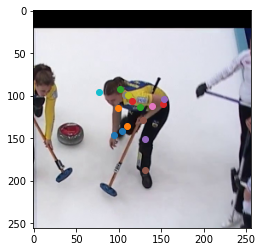

In [31]:
import matplotlib.pyplot as plt
plt.imshow(cropped/255)
for i in keypoints[0]:
    plt.scatter(i[0],i[1])

In [32]:
aug_rot=0
aug_rot=(np.random.random()*2-1)*30.
aug_rot

-11.273006582764797

In [33]:
aug_scale = np.random.random() * (1.25 - 0.75) + 0.75
aug_scale

1.0567906436892454

In [34]:
height, width = cropped.shape[0:2]

In [35]:
height, width

(256, 256)

In [36]:
center = np.array((width/2, height/2))

In [37]:
scale = max(height, width)/200

In [38]:
scale

1.28

In [39]:
scale *= aug_scale

In [40]:
mat_mask =img.get_transform(center, scale, (output_res, output_res), aug_rot)[:2]

In [41]:
mat = img.get_transform(center, scale, (input_res, input_res), aug_rot)[:2]

In [42]:
inp = cv2.warpAffine(cropped, mat, (input_res,input_res)).astype(np.float32)/255

In [43]:
mat_mask

array([[ 0.23200122, -0.04624476,  8.2231738 ],
       [ 0.04624476,  0.23200122, -3.61548553]])

In [44]:
keypoints[:,:,0:2]=img.kpt_affine(keypoints[:,:,0:2],mat_mask)

In [45]:
keypoints

array([[[25.78454409, 34.13814274,  1.        ],
        [27.45401998, 33.02360401,  1.        ],
        [31.99766779, 28.38124745,  0.        ],
        [38.40043496, 28.93385239,  1.        ],
        [31.6323741 , 37.4747623 ,  1.        ],
        [29.96756264, 45.82680613,  1.        ],
        [35.2919296 , 28.79667291,  0.        ],
        [28.70107377, 24.34706943,  0.        ],
        [29.39707743, 24.48580372,  1.        ],
        [21.64777031, 22.21747812,  1.        ],
        [23.27955287, 34.60369998,  1.        ],
        [25.87314661, 27.64288604,  1.        ],
        [27.40077859, 22.39934756,  0.        ],
        [30.23337017, 26.34103606,  1.        ],
        [38.90990475, 27.58808985,  1.        ],
        [32.18575645, 32.27824598,  1.        ]]])

In [46]:
if np.random.randint(2) == 0:
    inp = preprocess(inp)
    inp = inp[:, ::-1]
    keypoints = keypoints[:, ds.flipped_parts['mpii']]
    keypoints[:, :, 0] = output_res - keypoints[:, :, 0]
    orig_keypoints = orig_keypoints[:, ds.flipped_parts['mpii']]
    orig_keypoints[:, :, 0] = input_res - orig_keypoints[:, :, 0]

NameError: name 'self' is not defined

In [47]:
for i in range(np.shape(orig_keypoints)[1]):
    if kptmp[0,i,0] == 0 and kptmp[0,i,1] == 0:
        keypoints[0,i,0] = 0
        keypoints[0,i,1] = 0
        orig_keypoints[0,i,0] = 0
        orig_keypoints[0,i,1] = 0

In [60]:
orig_keypoints

array([[[104., 142.,   1.],
        [110., 136.,   1.],
        [125., 113.,   0.],
        [152., 110.,   1.],
        [131., 151.,   1.],
        [131., 187.,   1.],
        [139., 112.,   0.],
        [108.,  99.,   0.],
        [111.,  99.,   1.],
        [ 77.,  96.,   1.],
        [ 94., 146.,   1.],
        [ 99., 115.,   1.],
        [101.,  92.,   0.],
        [116., 106.,   1.],
        [153., 104.,   1.],
        [129., 129.,   1.]]])

In [61]:
keypoints

array([[[27.05307406, 36.84863287,  1.        ],
        [28.13724653, 35.03217711,  1.        ],
        [30.35948882, 28.55728554,  0.        ],
        [36.7028315 , 26.18449105,  1.        ],
        [34.12870005, 37.37646661,  1.        ],
        [36.32554996, 46.0783513 ,  1.        ],
        [33.68253147, 27.461236  ,  0.        ],
        [25.39593497, 26.21062062,  0.        ],
        [26.12109203, 26.02754979,  1.        ],
        [17.71957456, 27.37719543,  1.        ],
        [24.87997831, 38.42574503,  1.        ],
        [24.19684154, 30.6273374 ,  1.        ],
        [23.27673658, 24.94575275,  0.        ],
        [27.75685238, 27.41446488,  1.        ],
        [36.57840887, 24.67315333,  1.        ],
        [32.30274263, 32.18069541,  1.        ]]])

In [62]:
orig_keypoints

array([[[104., 142.,   1.],
        [110., 136.,   1.],
        [125., 113.,   0.],
        [152., 110.,   1.],
        [131., 151.,   1.],
        [131., 187.,   1.],
        [139., 112.,   0.],
        [108.,  99.,   0.],
        [111.,  99.,   1.],
        [ 77.,  96.,   1.],
        [ 94., 146.,   1.],
        [ 99., 115.,   1.],
        [101.,  92.,   0.],
        [116., 106.,   1.],
        [153., 104.,   1.],
        [129., 129.,   1.]]])

In [63]:
for p in keypoints:
    for idx, pt in enumerate(p):
        if pt[0] > 0: 
            x, y = int(pt[0]), int(pt[1])
            if x<0 or y<0 or x>=output_res or y>=output_res:
                continue
            ul = int(x - 3*sigma - 1), int(y - 3*sigma - 1)
            br = int(x + 3*sigma + 2), int(y + 3*sigma + 2)

            c,d = max(0, -ul[0]), min(br[0], output_res) - ul[0]
            a,b = max(0, -ul[1]), min(br[1], output_res) - ul[1]

            cc,dd = max(0, ul[0]), min(br[0], output_res)
            aa,bb = max(0, ul[1]), min(br[1], output_res)
            hms[idx, aa:bb,cc:dd] = np.maximum(hms[idx, aa:bb,cc:dd], g[a:b,c:d])

In [64]:
hms.shape

(16, 64, 64)

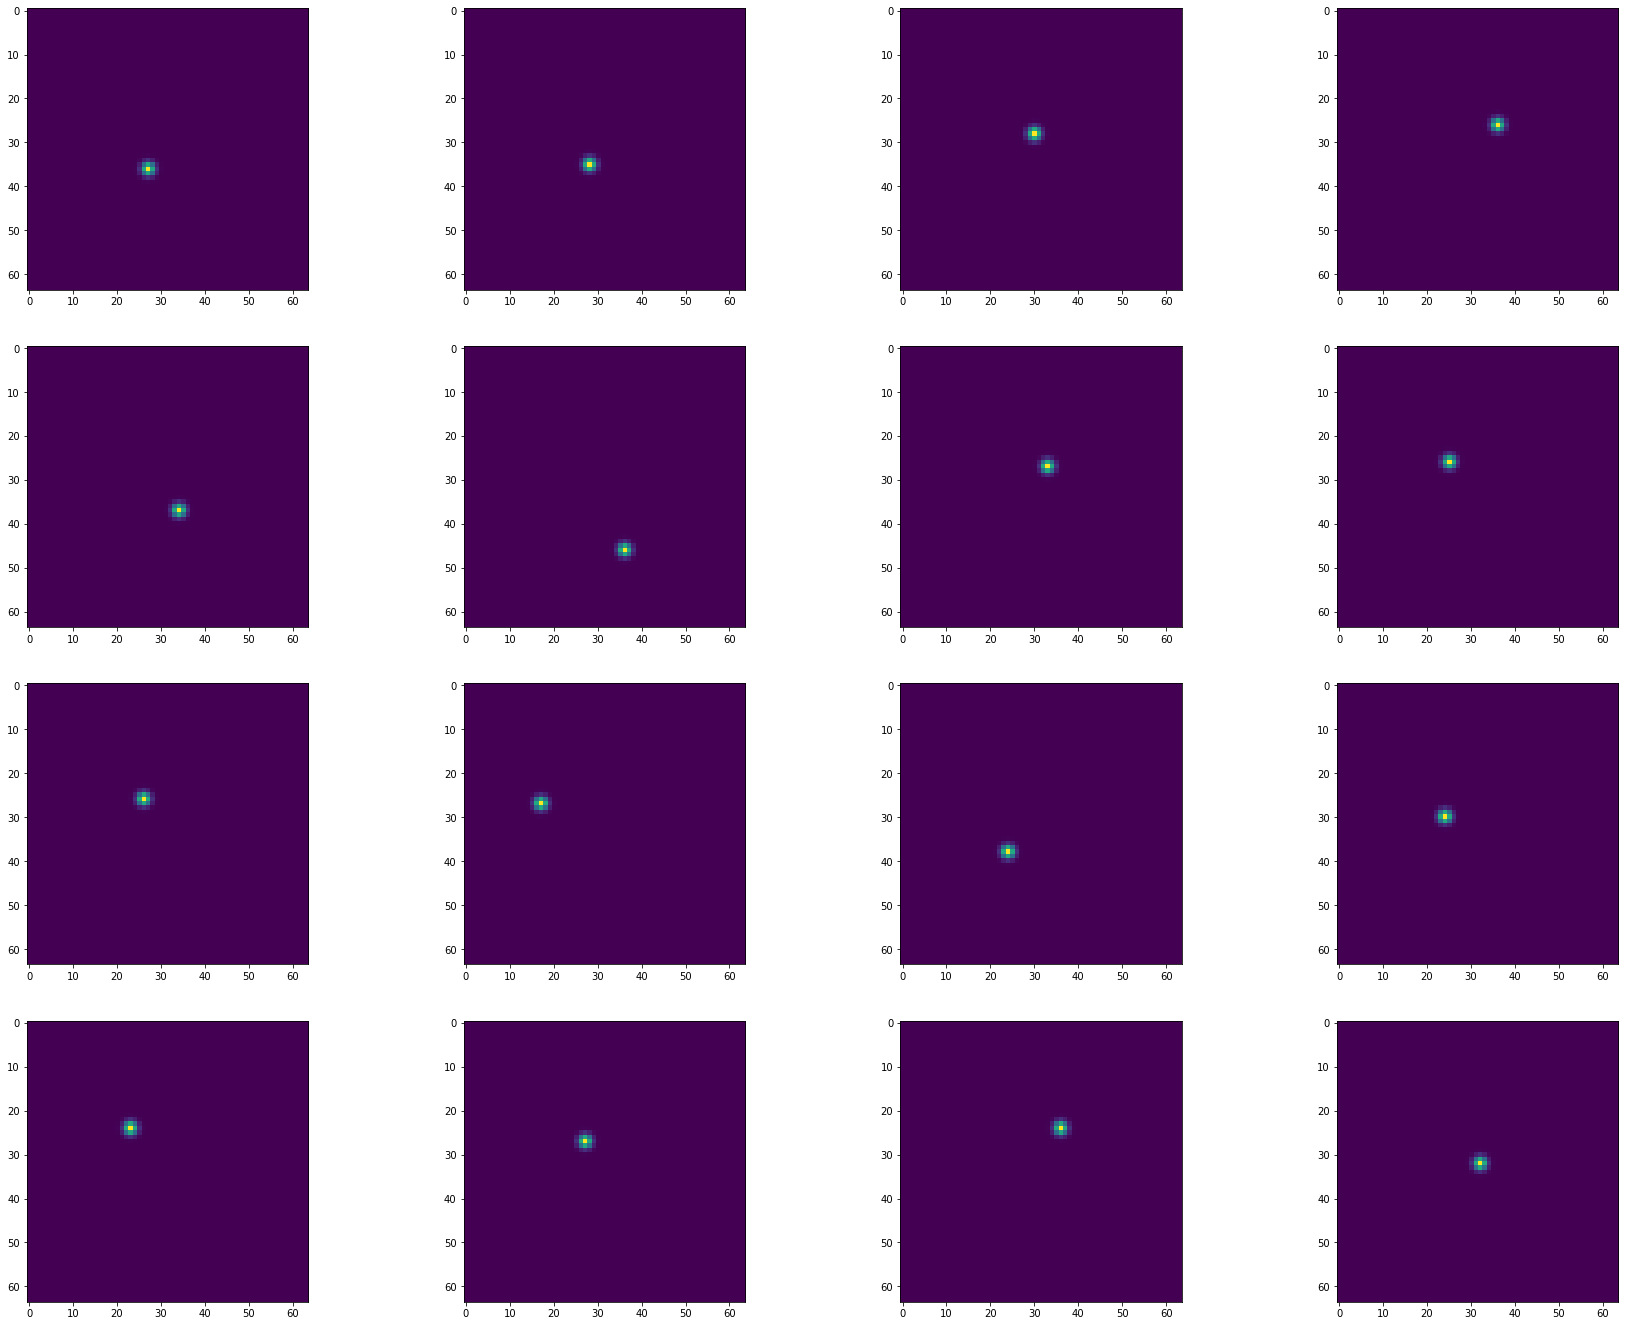

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
for n,i in enumerate(hms):
    plt.subplot(5,4,n+1)
    plt.imshow(i)

In [66]:
orig_keypoints

array([[[104., 142.,   1.],
        [110., 136.,   1.],
        [125., 113.,   0.],
        [152., 110.,   1.],
        [131., 151.,   1.],
        [131., 187.,   1.],
        [139., 112.,   0.],
        [108.,  99.,   0.],
        [111.,  99.,   1.],
        [ 77.,  96.,   1.],
        [ 94., 146.,   1.],
        [ 99., 115.,   1.],
        [101.,  92.,   0.],
        [116., 106.,   1.],
        [153., 104.,   1.],
        [129., 129.,   1.]]])

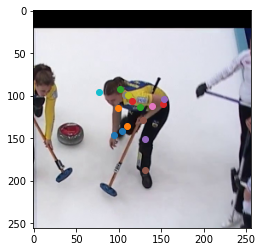

In [67]:
plt.imshow(cropped/255)
for i in orig_keypoints[0]:
    plt.scatter(i[0],i[1])

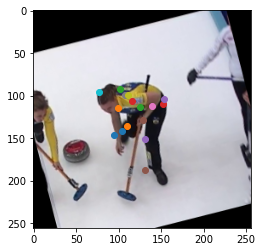

In [69]:
plt.imshow(inp)
for i in orig_keypoints[0]:
    plt.scatter(i[0],i[1])

In [71]:
inp1=cv2.resize(inp,dsize=(64,64),interpolation=cv2.INTER_AREA)

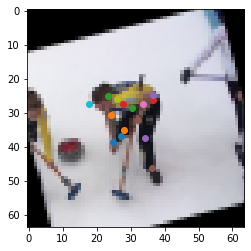

In [74]:
plt.imshow(inp1)
for i in keypoints[0]:
    plt.scatter(i[0],i[1])

In [92]:
########################### Change RGB COLOR #########################
def preprocess(data):
    # random hue and saturation
    data = cv2.cvtColor(data, cv2.COLOR_RGB2HSV);
    delta = (np.random.random() * 2 - 1) * 0.2
    print("delta : ", delta)
    print("cal : ",(delta * 360 + 360.), 360.)
    print("data : ",data[:,:,0].shape)
    data[:, :, 0] = np.mod(data[:,:,0] + (delta * 360 + 360.), 360.)

    delta_sature = np.random.random() + 0.5
    data[:, :, 1] *= delta_sature
    data[:,:, 1] = np.maximum( np.minimum(data[:,:,1], 1), 0 )
    data = cv2.cvtColor(data, cv2.COLOR_HSV2RGB)

    # adjust brightness
    delta = (np.random.random() * 2 - 1) * 0.3
    data += delta

    # adjust contrast
    mean = data.mean(axis=2, keepdims=True)
    data = (data - mean) * (np.random.random() + 0.5) + mean
    data = np.minimum(np.maximum(data, 0), 1)
    return data

In [93]:
data=preprocess(inp)

delta :  -0.004899402833362565
cal :  358.2362149799895 360.0
data :  (256, 256)


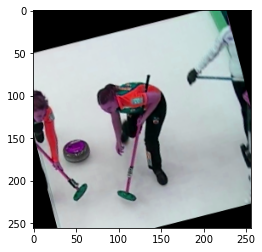

In [83]:
plt.imshow(data)

In [95]:
train, valid = ds.setup_val_split()

In [98]:
import dp
dataset={key: dp.Dataset(config,ds,data) for key, data in zip(['train','valid'],[train,valid])}

In [101]:
for key in dataset:
    print(key)

train
valid


# Num_worker => Use CPU Multicore (Hyperparameter)

In [103]:
loaders = {}
loaders['train']=torch.utils.data.DataLoader(dataset['train'],batch_size=batchsize,shuffle=True,pin_memory=False)

In [104]:
loaders['valid']=torch.utils.data.DataLoader(dataset['valid'],batch_size=batchsize,shuffle=True,pin_memory=False)

In [108]:
for i in dataset['train']:
    print(i[0].shape,i[1].shape)
    break

(256, 256, 3) (16, 64, 64)


# Part of gen

In [110]:
batchsize = config['train']['batchsize']
batchnum = config['train']['{}_iters'.format('train')]

In [111]:
loader = loaders['train'].__iter__()

In [117]:
for i in loader:
    print(i[0].shape, i[1].shape)
    break

torch.Size([16, 256, 256, 3]) torch.Size([16, 16, 64, 64])


In [118]:
imgs, heatmaps = next(loader)

In [119]:
imgs.shape

torch.Size([16, 256, 256, 3])